In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in the traning data
train_csv = pd.read_csv('recipe_train.csv')
train_csv.head()

,name,n_steps,n_ingredients,steps,ingredients,duration_label
0,wi gal s chicken rice stove top dish made heal...,6,12,"['in saucepan , melt margarine and combine wit...","['margarine', 'olive oil', 'celery', 'onion', ...",2.0
1,irish pin oats,9,5,['melt 1 tbs butter in a small saucepan over m...,"['butter', 'pinhead oats', 'water', 'half-and-...",2.0
2,cheesy beef n biscuit casserole,15,10,"['brown ground beef , onion and green pepper',...","['ground beef', 'onion', 'green pepper', 'toma...",2.0
3,lemonade chicken oamc,10,8,"['brown chicken in oil', 'combine all ingredie...","['boneless skinless chicken', 'frozen lemonade...",2.0
4,graham and peanut butter bon bons,6,5,"['set almond bark aside', 'mix remaining ingre...","['graham cracker crumbs', 'crunchy peanut butt...",2.0


In [3]:
# preprocess the texts
train_csv['steps'] = train_csv['steps'].apply(eval)
train_csv['ingredients'] = train_csv['ingredients'].apply(eval)
train_csv['steps'] = train_csv['steps'].apply(' '.join)
train_csv['ingredients'] = train_csv['ingredients'].apply(' '.join)

In [4]:
train_csv['duration_label'].value_counts()

2.0    20246
1.0    17705
3.0     2049
Name: duration_label, dtype: int64

In [5]:
# split data into train and development set
from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(train_csv.drop(columns='duration_label'), train_csv['duration_label'], test_size=0.25, random_state=3)

## Multinomial Naive Bayes---Count Vectoriser (name+steps+ingredients)

In [6]:
# combine the text of the recepie name, steps and ingredients
train_text = x_train['name'] + " " + x_train['steps'] + " " + x_train['ingredients'] 
dev_text = x_dev['name'] + " " + x_dev['steps'] + " " + x_dev['ingredients'] 

In [7]:
# process the train text to count vectoriser
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(stop_words='english').fit(train_text) 

In [8]:
x_train_steps_cv = cv.transform(train_text)
x_dev_steps_cv = cv.transform(dev_text)

In [9]:
# train the model using multinomial naive bayes and test the accuracy of the train & development set 
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train_steps_cv, y_train)
mnb.score(x_train_steps_cv, y_train), mnb.score(x_dev_steps_cv, y_dev)

(0.7538, 0.7213)

In [10]:
# use cross validation to check overfitting
from sklearn.model_selection import cross_val_score
cross_val_score(mnb, x_train_steps_cv, y_train).mean()

0.7236

By using the text of steps, ingredients and name combine together, we get a accuracy of 0.7213 for the development set. 
Try only use the text of steps(it have the most words hence we might get the most information form this feature), there is a slight imporvement. 
Then try add in the name feature, the accuracy have a further improvement compare to when we only use the steps.

## Multinomial Naive Bayes---Count Vectoriser (steps)

In [12]:
train_text1 = x_train['steps'] 
dev_text1 = x_dev['steps'] 
cv1 = CountVectorizer(stop_words='english').fit(train_text1)
x_train_steps_cv1 = cv.transform(train_text1)
x_dev_steps_cv1 = cv.transform(dev_text1)
mnb1 = MultinomialNB()
mnb1.fit(x_train_steps_cv1, y_train)
mnb1.score(x_train_steps_cv1, y_train), mnb.score(x_dev_steps_cv1, y_dev)

(0.7598666666666667, 0.7234)

In [13]:
cross_val_score(mnb, x_train_steps_cv1, y_train).mean()

0.7295999999999999

## Multinomial Naive Bayes---Count Vectoriser (name+steps)

In [14]:
train_text2 = x_train['name'] + " " + x_train['steps'] 
dev_text2 = x_dev['name'] + " " + x_dev['steps'] 
cv2 = CountVectorizer(stop_words='english').fit(train_text2)
x_train_steps_cv2 = cv.transform(train_text2)
x_dev_steps_cv2 = cv.transform(dev_text2)
mnb2 = MultinomialNB()
mnb2.fit(x_train_steps_cv2, y_train)
mnb2.score(x_train_steps_cv2, y_train), mnb.score(x_dev_steps_cv2, y_dev)

(0.7692666666666667, 0.7247)

In [15]:
cross_val_score(mnb, x_train_steps_cv2, y_train).mean()

0.7353333333333334

## Test on test set

In [16]:
test_csv = pd.read_csv('recipe_test.csv')

In [17]:
test_csv['steps'] = test_csv['steps'].apply(eval)
test_csv['ingredients'] = test_csv['ingredients'].apply(eval)
test_csv['steps'] = test_csv['steps'].apply(' '.join)
test_csv['ingredients'] = test_csv['ingredients'].apply(' '.join)
test_text = test_csv['name'] + " " + test_csv['steps'] + " " + test_csv['ingredients'] 
x_test_text_cv = cv.transform(test_text)

In [18]:
prediction = mnb.predict(x_test_text_cv)
prediction

array([2., 1., 2., ..., 1., 1., 2.])

In [19]:
results = pd.DataFrame({'id': list(range(1,10001)), 'duration_label': list(prediction)}, columns=['id', 'duration_label'])
results

,id,duration_label
0,1,2.0
1,2,1.0
2,3,2.0
3,4,1.0
4,5,2.0
...,...,...
9995,9996,2.0
9996,9997,2.0
9997,9998,1.0
9998,9999,1.0


In [20]:
results.to_csv("results.csv", index=False)

## Multinomial Naive Bayes---tfidf

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english').fit(x_train['steps'])
# train_text2 = name+steps
x_train_steps_tfidf = tfidf.transform(train_text2)
x_dev_steps_tfidf = tfidf.transform(dev_text2)

In [22]:
mnb3 = MultinomialNB()
mnb3.fit(x_train_steps_tfidf, y_train)
mnb3.score(x_train_steps_tfidf, y_train), mnb3.score(x_dev_steps_tfidf, y_dev)

(0.733, 0.6994)

Hence, we can see that by using tfidf to get the weight of each word does not produce a better performance for multinomial NB which is resonable since 

## Confusion Matrix (Precision & Recall) for baseline model

In [23]:
from sklearn.metrics import confusion_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

AttributeError: 'function' object has no attribute 'sum'

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
mnb_pred = mnb2.predict(x_dev_steps_cv2)
cm = confusion_matrix(y_dev, mnb_pred)
cm

array([[3169, 1204,  104],
       [1053, 3864,  109],
       [  86,   89,  322]], dtype=int64)

In [25]:
# precision & recall for base model
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
precision,recall

(array([0.73560817, 0.74927283, 0.60186916]),
 array([0.70784007, 0.76880223, 0.64788732]))

In [26]:
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP 
FN = np.sum(cm, axis=1) - TP
TP, FP, FN

(array([3169, 3864,  322], dtype=int64),
 array([1139, 1293,  213], dtype=int64),
 array([1308, 1162,  175], dtype=int64))

In [27]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
precision,recall

(array([0.73560817, 0.74927283, 0.60186916]),
 array([0.70784007, 0.76880223, 0.64788732]))

## Linear SVC---CV

In [28]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [63]:
svc = LinearSVC().fit(x_train_steps_cv2, y_train)
svc.score(x_train_steps_cv2, y_train), svc.score(x_dev_steps_cv, y_dev)

C:\Users\chloe\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


(0.9463666666666667, 0.7413)

## Linear SVC---tfidf

In [64]:
svc_tfidf = LinearSVC().fit(x_train_steps_tfidf, y_train)
svc_tfidf.score(x_train_steps_tfidf, y_train), svc_tfidf.score(x_dev_steps_tfidf, y_dev)

(0.8772, 0.7828)

## Logistic Regression---CV

In [33]:
lr = LogisticRegression(max_iter=1000).fit(x_train_steps_cv2, y_train)
lr.score(x_train_steps_cv2, y_train), lr.score(x_dev_steps_cv, y_dev)

(0.9208, 0.7639)

## Logistic Regression---tfidf

In [34]:
lr = LogisticRegression(max_iter=1000).fit(x_train_steps_tfidf, y_train)
lr.score(x_train_steps_tfidf, y_train), lr.score(x_dev_steps_tfidf, y_dev)

(0.8356333333333333, 0.7876)

## Grid Search use SDG

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [38]:
pipeline = Pipeline(
    [
        ('kbest', SelectKBest()), ('clf', SGDClassifier(random_state=2))
    ]
)
parameters = {
    'kbest__score_func': (f_classif, chi2),
    'kbest__k': (1000, 5000, 10000, 'all'),
    'clf__loss': ('hinge', 'log'),
    'clf__alpha': (1e-5, 1e-4, 1e-3, 1e-2),
}

In [39]:
def grid_search(pipeline, parameters, X, y):
    gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    gs.fit(X, y)
    
    mean_score = gs.cv_results_['mean_test_score']
    param_set = gs.cv_results_['params']
    for idx in mean_score.argsort()[-5:]:
        print(param_set[idx])
        print(gs.cv_results_['mean_test_score'][idx])
    
    return gs

In [40]:
result = grid_search(pipeline, parameters, x_train_steps_tfidf, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   22.4s finished


{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'kbest__k': 5000, 'kbest__score_func': <function chi2 at 0x0000022215AF0700>}
0.7865
{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'kbest__k': 5000, 'kbest__score_func': <function f_classif at 0x0000022215AF03A0>}
0.7869333333333334
{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'kbest__k': 10000, 'kbest__score_func': <function chi2 at 0x0000022215AF0700>}
0.7874
{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'kbest__k': 'all', 'kbest__score_func': <function f_classif at 0x0000022215AF03A0>}
0.7881
{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'kbest__k': 'all', 'kbest__score_func': <function chi2 at 0x0000022215AF0700>}
0.7881


From the result of the SDG classifier, we can see that the models with the top performance all have a alpha of 0.0001 and hinge loss. The score function does not make a much difference.

## Grid Search Only on SVC

In [41]:
pipeline = Pipeline([('kbest', SelectKBest()), ('clf', LinearSVC(max_iter=1000))])
parameters = {
    'kbest__k': (4000, 6000, 8000, 10000, 'all'),
    'clf__C': (0.1, 0.3, 0.5, 0.7, 1),
}
gs = grid_search(pipeline, parameters, x_train_steps_tfidf, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   16.1s finished


{'clf__C': 0.3, 'kbest__k': 10000}
0.7858333333333333
{'clf__C': 0.3, 'kbest__k': 4000}
0.7868000000000002
{'clf__C': 0.3, 'kbest__k': 'all'}
0.7869666666666666
{'clf__C': 0.3, 'kbest__k': 6000}
0.7872666666666668
{'clf__C': 0.3, 'kbest__k': 8000}
0.7875


Text(0.5, 15.0, 'kbest__k')

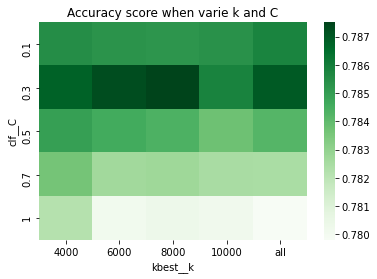

In [42]:
import seaborn as sns
scores = gs.cv_results_['mean_test_score'].reshape((5,5))
ax = plt.axes()
sns.heatmap(scores, xticklabels=parameters['kbest__k'], yticklabels=parameters['clf__C'], cmap='Greens')
ax.set_title('Accuracy score when varie k and C')
ax.set_ylabel('clf__C')    
ax.set_xlabel('kbest__k')

## Ensembel Model

### 1.max voting

In [45]:
# SGDClassifier
sgd = SGDClassifier(loss='log', max_iter=1000).fit(x_train_steps_tfidf, y_train)
sgd.score(x_train_steps_tfidf, y_train), sgd.score(x_dev_steps_tfidf, y_dev)

(0.8013, 0.7822)

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from statistics import mode

pred1=svc_tfidf.predict(x_dev_steps_tfidf)
pred2=lr.predict(x_dev_steps_tfidf)
pred3=sgd.predict(x_dev_steps_tfidf)

final_pred = np.array([])
for i in range(0,len(x_dev)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))
    
accuracy_train = accuracy_score(y_dev,final_pred)
accuracy_train

0.7882

### test on the test set use max voting

In [47]:
test_text = test_csv['name'] + " " + test_csv['steps']
x_test_steps_tfidf = tfidf.transform(test_text)

pred1_test=svc_tfidf.predict(x_test_steps_tfidf)
pred2_test=lr.predict(x_test_steps_tfidf)
pred3_test=sgd.predict(x_test_steps_tfidf)

prediction2 = np.array([])
for i in range(0,len(test_text)):
    prediction2 = np.append(prediction2, mode([pred1_test[i], pred2_test[i], pred3_test[i]]))
    
results2 = pd.DataFrame({'id': list(range(1,10001)), 'duration_label': list(prediction2)}, columns=['id', 'duration_label'])
results2.to_csv("results2.csv", index=False)

Result = 0.80166

### 2.Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
accuracy_train_list = []
for i in range(10,21):
    rf = RandomForestClassifier(max_depth=i)

    # fit the model with the training data
    rf.fit(x_train_steps_tfidf, y_train)

    # predict the target on the train dataset
    predict_train = rf.predict(x_dev_steps_tfidf)

    # Accuray Score on train dataset
    accuracy_train = accuracy_score(y_dev,predict_train)
    accuracy_train_list.append(accuracy_train)
accuracy_train_list

[0.7348,
 0.7328,
 0.7317,
 0.7333,
 0.738,
 0.7432,
 0.7378,
 0.7483,
 0.7495,
 0.7461,
 0.7547]

From the result we can see that the accuracy increase as the max depth of the tree increase.

In [50]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=40)

# fit the model with the training data
rf.fit(x_train_steps_tfidf, y_train)

# predict the target on the train dataset
predict_train = rf.predict(x_dev_steps_tfidf)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_dev,predict_train)
accuracy_train

0.7799

max_depth=40, n_estimators=100: 0.77
max_depth=40, n_estimators=200: 0.7776
max_depth=100, n_estimators=100: 0.778

varie the max depth or the number of trees can improve the accuracy but does not lead to a large change where it increases the complexity of the model.

## Test on testing set using Logistic Reg

In [51]:
prediction_lr = lr.predict(x_test_steps_tfidf)
results_lr = pd.DataFrame({'id': list(range(1,10001)), 'duration_label': list(prediction_lr)}, columns=['id', 'duration_label'])
results_lr.to_csv("results_lr.csv", index=False)

result = 0.80033

## Test on testing set with the tuned params using SVC

In [52]:
tuned_svc = LinearSVC(C=0.3, max_iter=8000).fit(x_train_steps_tfidf, y_train)
prediction_svc = tuned_svc.predict(x_test_steps_tfidf)
results_svc = pd.DataFrame({'id': list(range(1,10001)), 'duration_label': list(prediction_svc)}, columns=['id', 'duration_label'])
results_svc.to_csv("results_svc.csv", index=False)

Result = 0.79666

## Confusion Matrix (Precision & Recall)

In [53]:
# cm for log reg
lr_pred = lr.predict(x_dev_steps_tfidf)
cm2 = confusion_matrix(y_dev, lr_pred)
cm2

array([[3528,  902,   47],
       [ 937, 4054,   35],
       [  94,  109,  294]], dtype=int64)

In [54]:
recall2 = np.diag(cm2) / np.sum(cm2, axis = 1)
precision2 = np.diag(cm2) / np.sum(cm2, axis = 0)
precision2, recall2

(array([0.77385392, 0.80039487, 0.78191489]),
 array([0.7880277 , 0.80660565, 0.5915493 ]))

In [55]:
# cm for tuned svc 
tuned_svc_pred = tuned_svc.predict(x_dev_steps_tfidf)
cm3 = confusion_matrix(y_dev, tuned_svc_pred)
cm3

array([[3548,  896,   33],
       [ 963, 4035,   28],
       [  93,  108,  296]], dtype=int64)

In [56]:
recall3 = np.diag(cm3) / np.sum(cm3, axis = 1)
precision3 = np.diag(cm3) / np.sum(cm3, axis = 0)
precision3, recall3

(array([0.77063423, 0.80075412, 0.82913165]),
 array([0.79249497, 0.80282531, 0.59557344]))

In [57]:
# cm for tuned ensemble model 
pred1_dev=svc_tfidf.predict(x_dev_steps_tfidf)
pred2_dev=lr.predict(x_dev_steps_tfidf)
pred3_dev=sgd.predict(x_dev_steps_tfidf)

In [58]:
prediction_dev = np.array([])
for i in range(0,len(dev_text2)):
    prediction_dev = np.append(prediction_dev, mode([pred1_dev[i], pred2_dev[i], pred3_dev[i]]))
cm4 = confusion_matrix(y_dev, prediction_dev)
cm4

array([[3539,  904,   34],
       [ 939, 4055,   32],
       [  95,  114,  288]], dtype=int64)

In [59]:
recall4 = np.diag(cm4) / np.sum(cm4, axis = 1)
precision4 = np.diag(cm4) / np.sum(cm4, axis = 0)
precision4, recall4

(array([0.77389023, 0.79932979, 0.81355932]),
 array([0.7904847 , 0.80680462, 0.57947686]))

Generating Personalized Recipes from Historical User Preferences. Bodhisattwa Prasad Majumder, Shuyang Li,  Jianmo Ni,  Julian McAuley,  in Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 2019. 